TensorFlow MultiTask - Learns targets such as damage dealt & gold @ 10 mins in addition to match winner

In [2]:
from Learning import *
from Graphing import *

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [2]:
meta,X,X_rec,Yc,Yr,(meta_labels,X_labels,X_rec_labels,Yc_labels,Yr_labels) = load_ld("d_all_40k")

In [3]:
meta.shape, X.shape, len(X_labels), X_rec[0][0].shape, len(X_rec_labels), Yc.shape, Yr.shape

((39318, 26), (39318, 3642), 3642, (20, 121), 121, (39318, 13), (39318, 160))

Remove duplicates

In [85]:
if "X_rec_avgs" in locals() and X_rec_avgs.size and len(X_rec_avgs) == len(meta):
    meta, X, Yc, Yr, X_rec_avgs, X_rec = shuffle_data([meta, X, Yc, Yr, X_rec_avgs], X_rec)
else:
    meta, X, Yc, Yr, X_rec = shuffle_data([meta, X, Yc, Yr], X_rec)

In [86]:
meta, X, X_rec, Yc, Yr = remove_duplicate_players(meta, X, X_rec, Yc, Yr, meta_labels, elo_limit=None)

In [87]:
meta.shape, X.shape, len(X_labels), X_rec[0][0].shape, len(X_rec_labels), Yc.shape, Yr.shape

((15307, 26), (15307, 3642), 3642, (20, 121), 121, (15307, 13), (15307, 160))

Remove redundant features

In [4]:
X, X_labels, X_rec, X_rec_labels = remove_redundant_features(X, X_labels, X_rec, X_rec_labels)

In [5]:
meta.shape, X.shape, len(X_labels), X_rec[0][0].shape, len(X_rec_labels), Yc.shape, Yr.shape

((39318, 26), (39318, 2381), 2381, (20, 57), 57, (39318, 13), (39318, 160))

Exclude games for which we have no recent match history data (try including later)

In [6]:
rem_is = []
for i in range(len(meta)):
    if all([len(X_rec[i][j]) == 0 for j in N_PL_r]):
        rem_is.append(i)
len(rem_is)
meta, X, X_rec, Yc, Yr = remove_data_inds(meta, X, X_rec, Yc, Yr, rem_is)
meta.shape, X.shape, len(X_labels), X_rec[0][0].shape, len(X_rec_labels), Yc.shape, Yr.shape

((36117, 26), (36117, 2381), 2381, (20, 57), 57, (36117, 13), (36117, 160))

Shuffle data

In [7]:
if "X_rec_avgs" in locals() and X_rec_avgs.size and len(X_rec_avgs) == len(meta):
    meta, X, Yc, Yr, X_rec_avgs, X_rec = shuffle_data([meta, X, Yc, Yr, X_rec_avgs], X_rec)
else:
    meta, X, Yc, Yr, X_rec = shuffle_data([meta, X, Yc, Yr], X_rec)

Create team sum versions of regression targets

In [8]:
base_labels = []
r = t_roles[0]
r_len = len(r)
for l in Yr_labels:
    if l[:r_len] == r:
        base_labels.append( l[r_len + 1:] )
Yr_team = []
for l in base_labels:
    Yr_team.append( [Yr[:, Yr_labels.index(r + '_' + l)] for r in t_roles] )
    Yr_labels.append( "team_" + l )
Yr_team = np.sum(Yr_team, axis=1).T
Yr = np.hstack([Yr, Yr_team])
Yr.shape, len(Yr_labels)

((36117, 176), 176)

Data normalization/feature scaling (for data other than recent match histories)

In [9]:
print(Yr.min(), X.min(), Yr.max(), X.max()) # Scale data to between 0 & 1 (remember scaling values)
X_scales = scale_data(X, X_labels)
Yr_scales = scale_data(Yr, Yr_labels)
print(Yr.min(), X.min(), Yr.max(), X.max())

0.0 -68.0 3760742.0 1535854338645.0
0.0 0.0 1.0 1.0


In [43]:
# unscale_data(X, X_labels, X_scales) # Unscale
# unscale_data(Yr, Yr_labels, Yr_scales)
# print(Yr.min(), X.min(), Yr.max(), X.max())

(20, 126)

In [10]:
# Get the final form of recent games data (convert queue ids etc) (for now ignore champion, spells)
X_rec, X_rec_labels = get_rec_feats(X_rec, X_rec_labels)

36100 / 36117     


In [11]:
# Scale data to 0-1
X_rec = scale_rec_data(X_rec)

36100 / 36117     


In [12]:
len(X), X_rec[0][0].shape, len(X_rec_labels)

(36117, (20, 54), 54)

Remove game duration (win prediction use case)

In [13]:
X, X_labels = remove_data_subset(X, X_labels, duration_labels)
X.shape

(36117, 2380)

Define experiment models & variables

In [14]:
Yc_use = [
    "blue_win",
#     "blue_first_tower",
#     "blue_first_dragon",
    "blue_first_inhib",
#     "blue_first_blood",
#     "blue_rift_herald",
#     "blue_first_baron",
]
Yr_use = sum([[role + '_' + l for l in [
#     "total_damage_dealt_to_champions",
#     "total_time_crowd_control_dealt",
#     "time_ccing_others",
#     "vision_score",
#     "gold",
#     "gold_10min",
#     "xp_10min",
]] for role in t_roles], []) + [
    "team_total_damage_dealt_to_champions",
#     "team_total_time_crowd_control_dealt", # ?
    "team_time_ccing_others",
    "team_vision_score", # ?
    "team_gold",
    "team_gold_10min",
#     "team_xp_10min",
]

rec_max_len = 20 # Maximum number of recent games to use in RNN

Yc_targets = []
for l in Yc_use: # Get one-hot version of classification targets
    Yc_t = np.atleast_2d(Yc[:, Yc_labels.index(l)])
    Yc_t_ = np.zeros((Yc_t.size, int(Yc_t.max()) + 1))
    Yc_t_[np.arange(Yc_t.size), (Yc_t).astype(np.int)] = 1
    Yc_targets.append(Yc_t_)
Yr_targets = [np.atleast_2d(Yr[:, Yr_labels.index(l)]).T for l in Yr_use]

# Number of test samples
n_test = 1000
X_train, X_test = X[:-n_test], X[-n_test:]
Yc_train, Yc_test = [Yc_[:-n_test] for Yc_ in Yc_targets], [Yc_[-n_test:] for Yc_ in Yc_targets]
Yr_train, Yr_test = [Yr_[:-n_test] for Yr_ in Yr_targets], [Yr_[-n_test:] for Yr_ in Yr_targets]
n_train, n_features, n_rec_features = X_train.shape[0], X_train.shape[1], len(X_rec_labels)
n_outputs = [Yc_.shape[1] for Yc_ in Yc_train]
X.shape, n_train, n_test, n_features, n_outputs, len(Yc_targets), len(Yr_targets), Yc_targets[0].shape, Yr_targets[0].shape, \
    rec_max_len, n_rec_features

((36117, 2380),
 35117,
 1000,
 2380,
 [2, 2],
 2,
 5,
 (36117, 2),
 (36117, 1),
 20,
 54)

In [15]:
# Convert recent games data into appropriate format to feed into RNN 
# 10 numpy arrays (for each player in a match), each of shape (batch_size, rec_max_len, n_rec_features)
# + 10 numpy arrays with the sequence lengths, each of shape (batch_size, seq_lens)
# inds = indices of the 
def convert_X_rec(X_rec, inds=None, max_len=None):
    if inds is not None:
        X_rec_ = X_rec[inds]
    else:
        X_rec_ = X_rec
    if max_len is None:
        max_len = 20
    xrs_seqlens = [np.array([min(max(xr[j].shape[0], 1), max_len) for xr in X_rec_]) for j in N_PL_r]
    xrs = [np.array([np.pad(xr[j][-max_len:], [(0, max_len - xr[j][-max_len:].shape[0]), (0, 0)], \
           'constant') if len(xr[j]) != 0 else np.zeros((max_len, n_rec_features)) for xr in X_rec_]) for j in N_PL_r]
    return xrs, xrs_seqlens
Xr, Xr_seqlens = convert_X_rec(X_rec, max_len=rec_max_len)
Xr_train, Xr_test = [xr[:-n_test] for xr in Xr], [xr[-n_test:] for xr in Xr]
Xr_sl_train, Xr_sl_test = [xr_sl[:-n_test] for xr_sl in Xr_seqlens], [xr_sl[-n_test:] for xr_sl in Xr_seqlens]
Xr_train[0].shape, Xr_test[0].shape, Xr_sl_train[0].shape, Xr_sl_test[0].shape

((35117, 20, 54), (1000, 20, 54), (35117,), (1000,))

Filter test data to test prediction for games above an elo skill rating of ```elo_N```

In [49]:
elo_N = 2400
test_is = np.nonzero(meta[2000:, meta_labels.index("elo")] > elo_N)[0]
len(test_is)
# X_test, Y_test = X_test[test_is], Y_test[test_is]
# X_test.shape, Y_test.shape

2657

Fit, train & test models, save result (naming format: predictions_startNumSamples_endNumSamples_numEvalSamples_featuresUsed)

Epoch 2106 : 0.99259573 0.803 9.105634 13.352285  Best test acc: 0.839


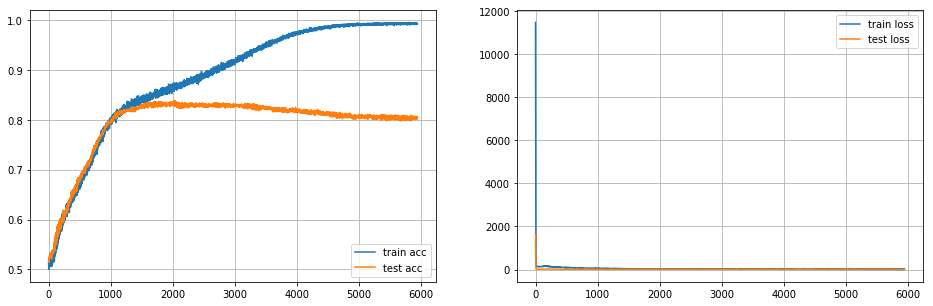

KeyboardInterrupt: 

In [25]:
import tensorflow as tf
from tensorflow.contrib import rnn
from IPython.display import clear_output

# Define next batch function
current_i, epochs_completed = 0, 0
def next_batch(b_size):
    global current_i, epochs_completed
    xs = X_train[current_i:current_i + b_size]
    xrs = [Xr_[current_i:current_i + b_size] for Xr_ in Xr_train]
    xrsls = [Xr_sl_[current_i:current_i + b_size] for Xr_sl_ in Xr_sl_train]
    ycs = [Yc_[current_i:current_i + b_size] for Yc_ in Yc_train]
    yrs = [Yr_[current_i:current_i + b_size] for Yr_ in Yr_train]
    current_i += b_size
    if current_i >= n_train:
        current_i = 0
        epochs_completed += 1
    return xs, xrs, xrsls, ycs, yrs
    
blue_win_i = Yc_use.index("blue_win")
train_set_test_frac = 0.2 # Get training accuracy for random 20% subset of train set
log_period_batches = 50
n_epochs = 500000
# learning_rate=0.000012
# learning_rate=0.00000015
learning_rate = 0.000001
learning_rate_gd = 0.01
dropout_keep_prob = 0.825
batch_size = 250
l1_n_units = 1024
l2_n_units = 1024
l3_n_units = 1024
l4_n_units = 1024
# l5_n_units = 1024
# l6_n_units = 1024
final_layer_units = 1024
post_rnn_units = 64
n_rnn_units = 16
n_rnn_stacked = 1
lstm_forget_bias = 1.0
c_type = "GRU"

n_train_test = int(train_set_test_frac * n_train)
izer = tf.contrib.layers.xavier_initializer()
tf.reset_default_graph()
train_accuracy, test_accuracy, train_loss, test_loss = [], [], [], []

x = tf.placeholder(tf.float32, [None, n_features])
xr = [tf.placeholder(tf.float32, [None, rec_max_len, n_rec_features]) for _ in N_PL_r]
xrsl = [tf.placeholder(tf.int32, [None]) for _ in N_PL_r]
yc = [tf.placeholder(tf.float32, [None, n_outputs[i]]) for i in range(len(Yc_targets))]
yr = [tf.placeholder(tf.float32, [None, 1]) for _ in range(len(Yr_targets))]
keep_prob = tf.placeholder(tf.float32)

W_1 = tf.Variable(izer([n_features, l1_n_units]))
b_1 = tf.Variable(izer([l1_n_units]))
W_2 = tf.Variable(izer([l1_n_units, l2_n_units]))
b_2 = tf.Variable(izer([l2_n_units]))
W_3 = tf.Variable(izer([l2_n_units, l3_n_units]))
b_3 = tf.Variable(izer([l3_n_units]))
W_4 = tf.Variable(izer([l3_n_units, l4_n_units]))
b_4 = tf.Variable(izer([l4_n_units]))
# W_5 = tf.Variable(izer([l4_n_units, l5_n_units]))
# b_5 = tf.Variable(izer([l5_n_units]))
# W_6 = tf.Variable(izer([l5_n_units, l6_n_units]))
# b_6 = tf.Variable(izer([l6_n_units]))
# W_7 = tf.Variable(izer([l6_n_units, n_outputs]))
# b_7 = tf.Variable(izer([n_outputs]))

Yc_W1s = [tf.Variable(izer([l4_n_units, final_layer_units])) for _ in range(len(Yc_targets))]
Yc_b1s = [tf.Variable(izer([final_layer_units])) for _ in range(len(Yc_targets))]
Yc_W2s = [tf.Variable(izer([final_layer_units, n_outputs[i]])) for i in range(len(Yc_targets))]
Yc_b2s = [tf.Variable(izer([n_outputs[i]])) for i in range(len(Yc_targets))]
Yr_W1s = [tf.Variable(izer([l4_n_units, final_layer_units])) for _ in range(len(Yr_targets))]
Yr_b1s = [tf.Variable(izer([final_layer_units])) for _ in range(len(Yr_targets))]
Yr_W2s = [tf.Variable(izer([final_layer_units, 1])) for _ in range(len(Yr_targets))]
Yr_b2s = [tf.Variable(izer([1])) for _ in range(len(Yr_targets))]

Xr_W1s = [tf.Variable(izer([n_rnn_units, post_rnn_units])) for _ in N_PL_r]
Xr_b1s = [tf.Variable(izer([post_rnn_units])) for _ in N_PL_r]
Xr_W2s = [tf.Variable(izer([post_rnn_units, l1_n_units])) for _ in N_PL_r]
# Xr_b2s = [tf.Variable(izer([l1_n_units])) for _ in N_PL_r]

def get_rnn_cell(c_type, lstm_forget_bias, keep_prob):
  cell = rnn.GRUCell(n_rnn_units) if c_type == "GRU" else \
         rnn.LSTMCell(n_rnn_units, forget_bias=lstm_forget_bias)
  return rnn.DropoutWrapper(cell, input_keep_prob=1.0, output_keep_prob=keep_prob)
if n_rnn_stacked > 1:
    cell = rnn.MultiRNNCell([get_rnn_cell(c_type, lstm_forget_bias, keep_prob) for _ in range(n_rnn_stacked)])
else:
    cell = get_rnn_cell(c_type, lstm_forget_bias, keep_prob)
    
rnn_os, rnn_states = zip(*[tf.nn.dynamic_rnn(cell, xr[i], sequence_length=xrsl[i], dtype=tf.float32) for i in N_PL_r])
cur_b_size = tf.shape(xrsl[0])[0]
rnn_outs = [tf.gather_nd(rnn_os[i], tf.stack([xrsl[i] - 1, tf.range(cur_b_size)], axis=1)) for i in N_PL_r]
post_rnn_layers = [tf.nn.relu(tf.matmul(rnn_outs[i], Xr_W1s[i]) + Xr_b1s[i]) for i in N_PL_r]
rnn_l1 = [tf.matmul(post_rnn_layers[i], Xr_W2s[i]) for i in N_PL_r]

# relu_1 = tf.nn.relu(tf.matmul(x, W_1) + b_1)
relu_1 = tf.nn.relu(tf.matmul(x, W_1) + b_1 + sum(rnn_l1))
# relu_2 = tf.layers.batch_normalization(tf.nn.relu(tf.matmul(relu_1, W_2) + b_2))
relu_2 = tf.nn.dropout(tf.nn.relu(tf.matmul(relu_1, W_2) + b_2), keep_prob)
# relu_2 = tf.nn.relu(tf.matmul(relu_1, W_2) + b_2)
relu_3 = tf.nn.relu(tf.matmul(relu_2, W_3) + b_3)
# relu_3 = tf.nn.dropout(tf.nn.relu(tf.matmul(relu_2, W_3) + b_3), keep_prob)
relu_4 = tf.nn.relu(tf.matmul(relu_3, W_4) + b_4)
# relu_5 = tf.nn.relu(tf.matmul(relu_4, W_5) + b_5)
# relu_6 = tf.nn.relu(tf.matmul(relu_5, W_6) + b_6)
# drop_out = tf.nn.dropout(relu_2, keep_prob)
# y_out = tf.matmul(drop_out, W_3) + b_3
# y_out = tf.matmul(relu_3, W_4) + b_4
#   y_prob = tf.nn.softmax(y_out)

Yc_layers = [tf.nn.relu(tf.matmul(relu_4, Yc_W1s[i]) + Yc_b1s[i]) for i in range(len(Yc_targets))]
Yc_outs = [tf.matmul(Yc_layers[i], Yc_W2s[i]) + Yc_b2s[i] for i in range(len(Yc_targets))]
Yr_layers = [tf.nn.relu(tf.matmul(relu_4, Yr_W1s[i]) + Yr_b1s[i]) for i in range(len(Yr_targets))]
Yr_outs = [tf.matmul(Yr_layers[i], Yr_W2s[i]) + Yr_b2s[i] for i in range(len(Yr_targets))]

# Define loss function & training step
Yc_losses = [tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
             labels=yc[i], logits=Yc_outs[i])) for i in range(len(Yc_targets))]
Yr_losses = [tf.reduce_mean(tf.nn.l2_loss(yr[i] - Yr_outs[i])) for i in range(len(Yr_targets))]
loss = sum(Yc_losses + Yr_losses)
# loss = sum(Yc_losses) + sum(Yr_losses)
train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

# cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_out))
# train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cross_entropy)
# train_step = tf.train.GradientDescentOptimizer(learning_rate_gd).minimize(cross_entropy)

# Define accuracy computation
correct = tf.equal(tf.argmax(Yc_outs[blue_win_i], 1), tf.argmax(yc[blue_win_i], 1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

# Train
batch_i = 0
with tf.train.MonitoredSession() as sess:
    while epochs_completed < n_epochs:
        
        batch_i += 1
        batch_xs, batch_xrs, batch_xrsls, batch_ycs, batch_yrs = next_batch(batch_size)
        xrs_feed = {xr[i]: batch_xrs[i] for i in N_PL_r}
        xrsls_feed = {xrsl[i]: batch_xrsls[i] for i in N_PL_r}
        ycs_feed = {yc[i]: batch_ycs[i] for i in range(len(Yc_targets))}
        yrs_feed = {yr[i]: batch_yrs[i] for i in range(len(Yr_targets))}
        sess.run(train_step, feed_dict={**ycs_feed,**yrs_feed,**xrs_feed,**xrsls_feed, \
                                        **{x: batch_xs, keep_prob: dropout_keep_prob}})

        if batch_i % log_period_batches == 0:

            # Get random sample of 20% of the training dataset
            indices = np.random.choice(n_train, n_train_test, replace=False)
            xrs_feed = {xr[i]: Xr_train[i][indices] for i in N_PL_r}
            xrsls_feed = {xrsl[i]: Xr_sl_train[i][indices] for i in N_PL_r}
            ycs_feed = {yc[i]: Yc_train[i][indices] for i in range(len(Yc_targets))}
            yrs_feed = {yr[i]: Yr_train[i][indices] for i in range(len(Yr_targets))}
            train_l, train_a = sess.run([loss, accuracy], feed_dict={**ycs_feed,**yrs_feed,**xrs_feed,**xrsls_feed, \
                                                                     **{x: X_train[indices], keep_prob: 1.0}})
            
            xrs_feed = {xr[i]: Xr_test[i] for i in N_PL_r}
            xrsls_feed = {xrsl[i]: Xr_sl_test[i] for i in N_PL_r}
            ycs_feed = {yc[i]: Yc_test[i] for i in range(len(Yc_targets))}
            yrs_feed = {yr[i]: Yr_test[i] for i in range(len(Yr_targets))}
            test_l, test_a = sess.run([loss, accuracy], feed_dict={**ycs_feed,**yrs_feed,**xrs_feed,**xrsls_feed, \
                                                                   **{x: X_test, keep_prob: 1.0}})
            
            train_loss += [ train_l ]
            train_accuracy += [ train_a ]
            test_loss += [ test_l ]
            test_accuracy += [ test_a ]
            
            clear_output()
            print("Epoch", epochs_completed, ':', train_a, test_a, train_l, test_l, " Best test acc:", max(test_accuracy))
            fig = plt.figure()
            fig.set_size_inches(16, 5)
            g = fig.add_subplot(1,2,1)
            g.grid()
            g.plot(train_accuracy, label='train acc')
            g.plot(test_accuracy, label='test acc')
            g.legend(loc='lower right')
    
            g = fig.add_subplot(1,2,2)
            g.grid()
            g.plot(train_loss, label='train loss')
            g.plot(test_loss, label='test loss')
            g.legend(loc='upper right')
    
            plt.show()

In [97]:
# # Merge champion representations ( doesn't improve anything ):
# top_champ_is = {}
# top_champ_is["blue"] = [i for i in range(len(X_labels)) if "blue_top_champion__x" in X_labels[i]]
# top_champ_is["red"] = [i for i in range(len(X_labels)) if "red_top_champion__x" in X_labels[i]]
# rem_is = []
# for side in cols_all:
#     for role in ['jungle', 'middle', 'support', 'adc']:
#         r = side + '_' + role
#         r_champ_is = [i for i in range(len(X_labels)) if r + "_champion__x" in X_labels[i]]
#         rem_is += r_champ_is
#         X[top_champ_is[side]] += X[r_champ_is]
# X = np.delete(X, rem_is, axis=1)
# X_labels = [X_labels[i] for i in range(len(X_labels)) if i not in rem_is]